In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform = transforms.ToTensor()

# Download and load the MNIST training data
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Filter the dataset to include only images with label 9 and 5
label_9_indices = [i for i, (_, label) in enumerate(train_data) if label == 9]
label_5_indices = [i for i, (_, label) in enumerate(train_data) if label == 5]

# Calculate the number of samples for each label based on the desired proportions
num_label_9 = int(0.9 * len(label_9_indices))
num_label_5 = int(0.1 * len(label_5_indices))

# Randomly sample images with label 9 and label 5
selected_label_9_indices = np.random.choice(label_9_indices, num_label_9, replace=False)
selected_label_5_indices = np.random.choice(label_5_indices, num_label_5, replace=False)

# Combine the selected indices
selected_indices = np.concatenate([selected_label_9_indices, selected_label_5_indices])

# Create a Subset of the original dataset with the selected indices
filtered_dataset = torch.utils.data.Subset(train_data, selected_indices)

print(len(filtered_dataset))

# Create a DataLoader to iterate through the filtered dataset
batch_size = 64
train_loader = torch.utils.data.DataLoader(filtered_dataset, batch_size=batch_size, shuffle=True)

5896


In [3]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

In [5]:
model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)


In [6]:
# Point to training loop video
num_epochs = 20
outputs = []
for epoch in range(num_epochs):
    for (img, _) in train_loader:
        # img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0453
Epoch:2, Loss:0.0282
Epoch:3, Loss:0.0222
Epoch:4, Loss:0.0157
Epoch:5, Loss:0.0106
Epoch:6, Loss:0.0121
Epoch:7, Loss:0.0090
Epoch:8, Loss:0.0085
Epoch:9, Loss:0.0114
Epoch:10, Loss:0.0069
Epoch:11, Loss:0.0067
Epoch:12, Loss:0.0047
Epoch:13, Loss:0.0062
Epoch:14, Loss:0.0059
Epoch:15, Loss:0.0054
Epoch:16, Loss:0.0043
Epoch:17, Loss:0.0066
Epoch:18, Loss:0.0064
Epoch:19, Loss:0.0038
Epoch:20, Loss:0.0041


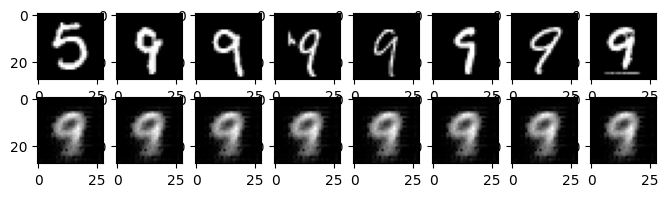

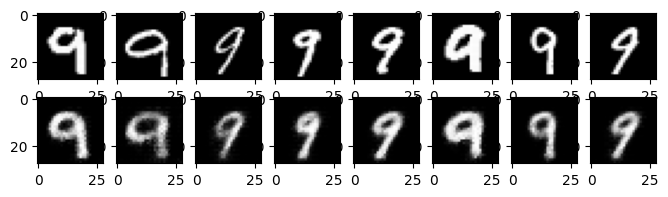

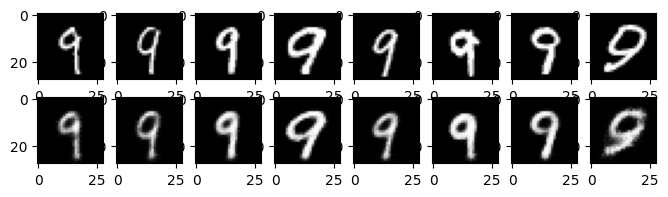

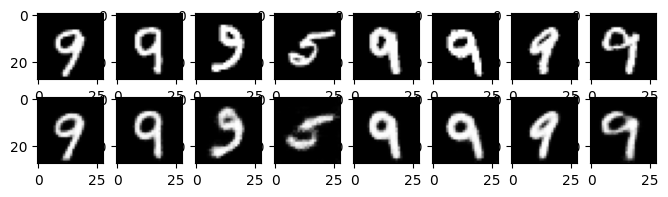

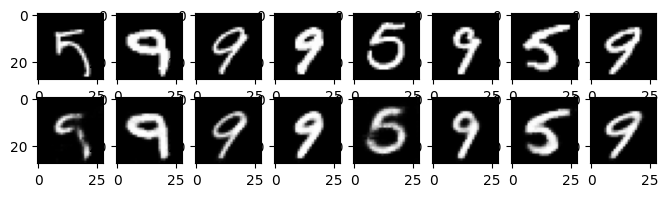

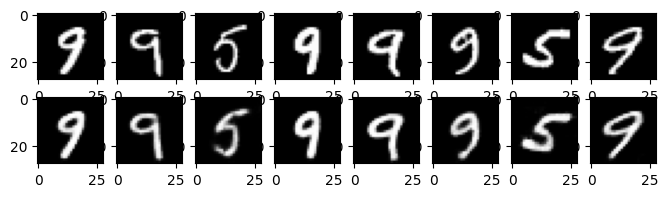

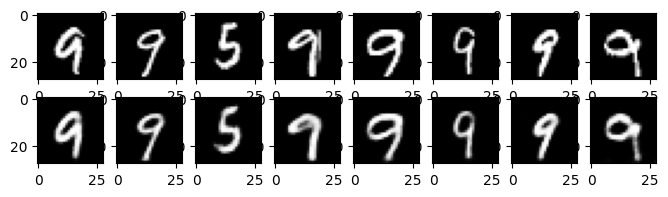

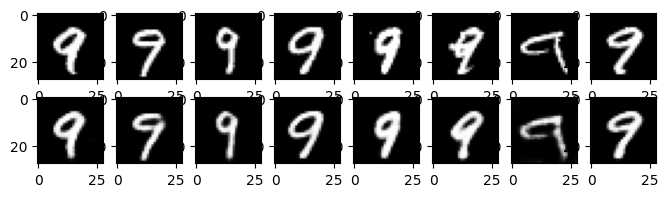

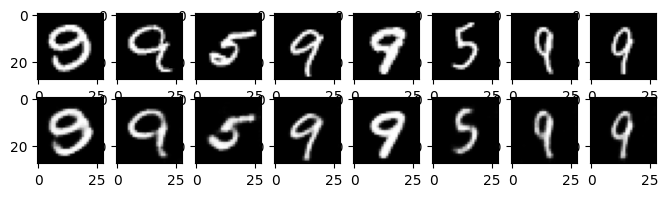

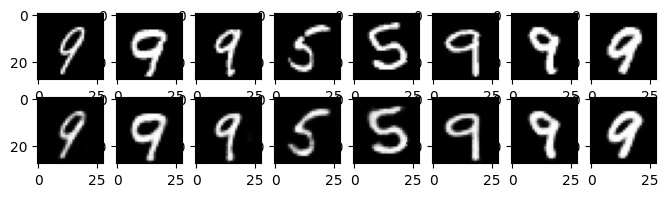

In [7]:
for k in range(0, num_epochs, 2):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

